In [1]:
import sys
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.decomposition as dec
import sklearn.model_selection as modsel
import sklearn.preprocessing as prep
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import confusion_matrix as cm

# 0. Define some functions

In [2]:
def split(dataset, column):
    X, Y = dataset.drop(column, axis=1), dataset[column]
    return X, Y

def tt_split(X, Y, ts=0.5, rs=None, sh=False):
    X_train, X_test, Y_train, Y_test = modsel.train_test_split(X, Y, train_size=ts, random_state=rs, shuffle=sh)
    return X_train, X_test, Y_train, Y_test

def extremums(array):
    extras = []
    for parameter in array:
        new_extras = [min(parameter), max(parameter)]
        extras.append(new_extras)
    return extras

def normalize(array):
    minimum, maximum = min(array), max(array)
    for i in range(len(array)):
        array[i] = (array[i]-minimum)/maximum

def test_metrics(test, predicted):
    print(cm(test, predicted)) 
    print("\n Mean Squeared Error =", mse(test, predicted))

### Dataset description

In [3]:
dataframe = pd.read_excel("job_satisfaction_train.xlsx", sheet_name = "demo")

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 29 columns):
age         6400 non-null int64
marital     6400 non-null int64
address     6400 non-null int64
income      6400 non-null int64
inccat      6400 non-null int64
car         6400 non-null float64
carcat      6400 non-null int64
ed          6400 non-null int64
employ      6400 non-null int64
retire      6400 non-null int64
empcat      6400 non-null int64
jobsat      5400 non-null float64
gender      6400 non-null object
reside      6400 non-null int64
wireless    6400 non-null int64
multline    6400 non-null int64
voice       6400 non-null int64
pager       6400 non-null int64
internet    6400 non-null int64
callid      6400 non-null int64
callwait    6400 non-null int64
owntv       6400 non-null int64
ownvcr      6400 non-null int64
owncd       6400 non-null int64
ownpda      6400 non-null int64
ownpc       6400 non-null int64
ownfax      6400 non-null int64
news        6400 non-nul

### Simple changes

In [5]:
dataframe["gender"] = np.where(dataframe["gender"]=="f", np.int64(1), np.int64(0))

### Split for known and unknown data

In [6]:
known, predict = dataframe.iloc[0:5400], dataframe.iloc[5400:]

In [27]:
# plt.figure(figsize=(20,10))
# sns.distplot(train.jobsat, color="tomato")
# plt.title("jobsat in train")
# plt.ylabel("Density");

# 1. Preprocessing

In [7]:
x_known, y_known = split(known, column="jobsat")
yknown = np.array(y_known)

### 1.1 Features extraction

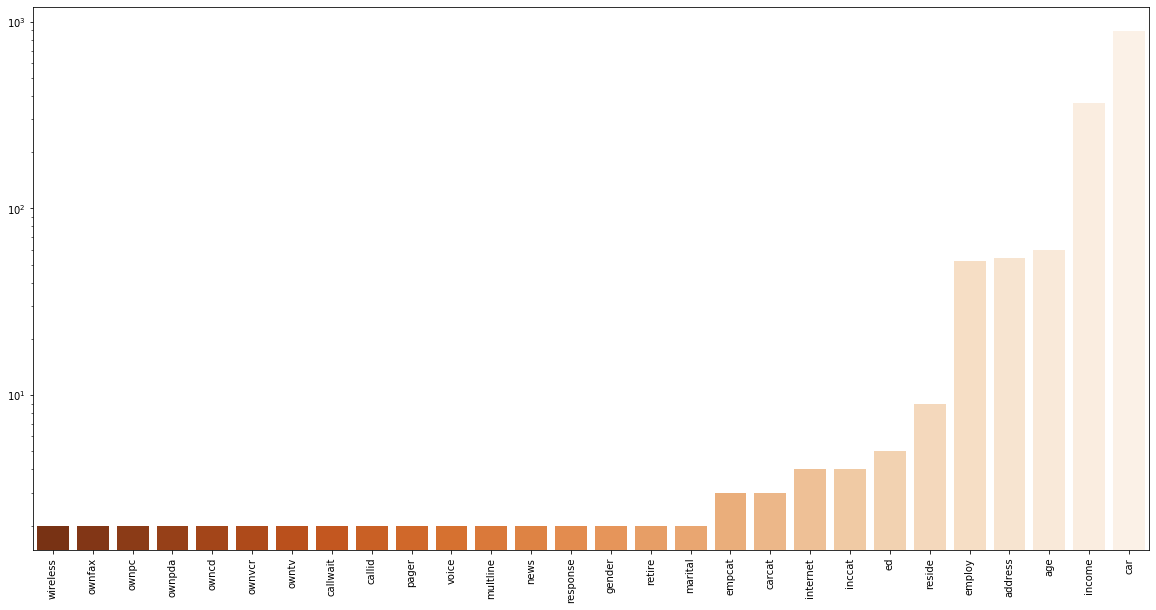

In [8]:
features = list(x_known.dtypes.index.values)
unique_counts = x_known.loc[:, features].nunique().sort_values()
plt.figure(figsize=(20,10))
sns.barplot(unique_counts.index, unique_counts.values, palette="Oranges_r")
plt.xticks(rotation=90)
plt.yscale("log");

In [9]:
bin_candidates = [elem for elem in features if len(set(x_known[elem])) == 2]
num_candidates = [elem for elem in features if len(set(x_known[elem])) >= 10**1.5]
cat_candidates = list(set(features) - set(num_candidates) - set(bin_candidates))

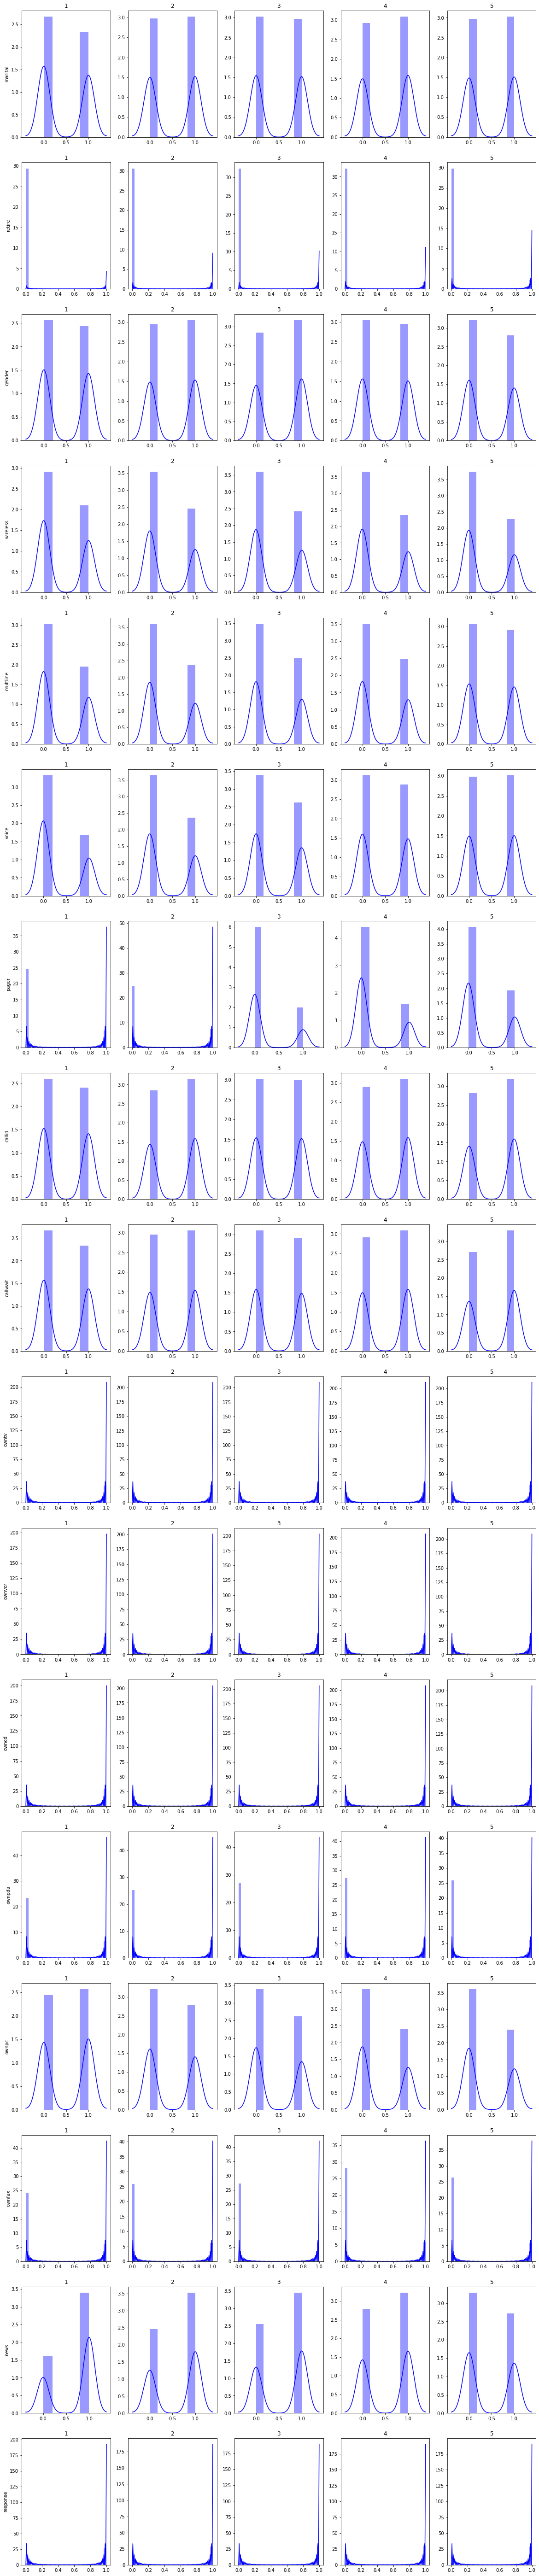

In [10]:
#bin_candidates
fig, ax = plt.subplots(len(bin_candidates),5,figsize=(20,len(bin_candidates)*6))
for n in range(len(bin_candidates)):
    feat = bin_candidates[n]
    for i in range(5):
        sns.distplot(np.array(known.loc[known['jobsat']==i+1][feat]), kde=True, ax=ax[n,i], color="Blue")
        ax[n,0].set_ylabel(feat)
        ax[n,i].set_title(i+1)

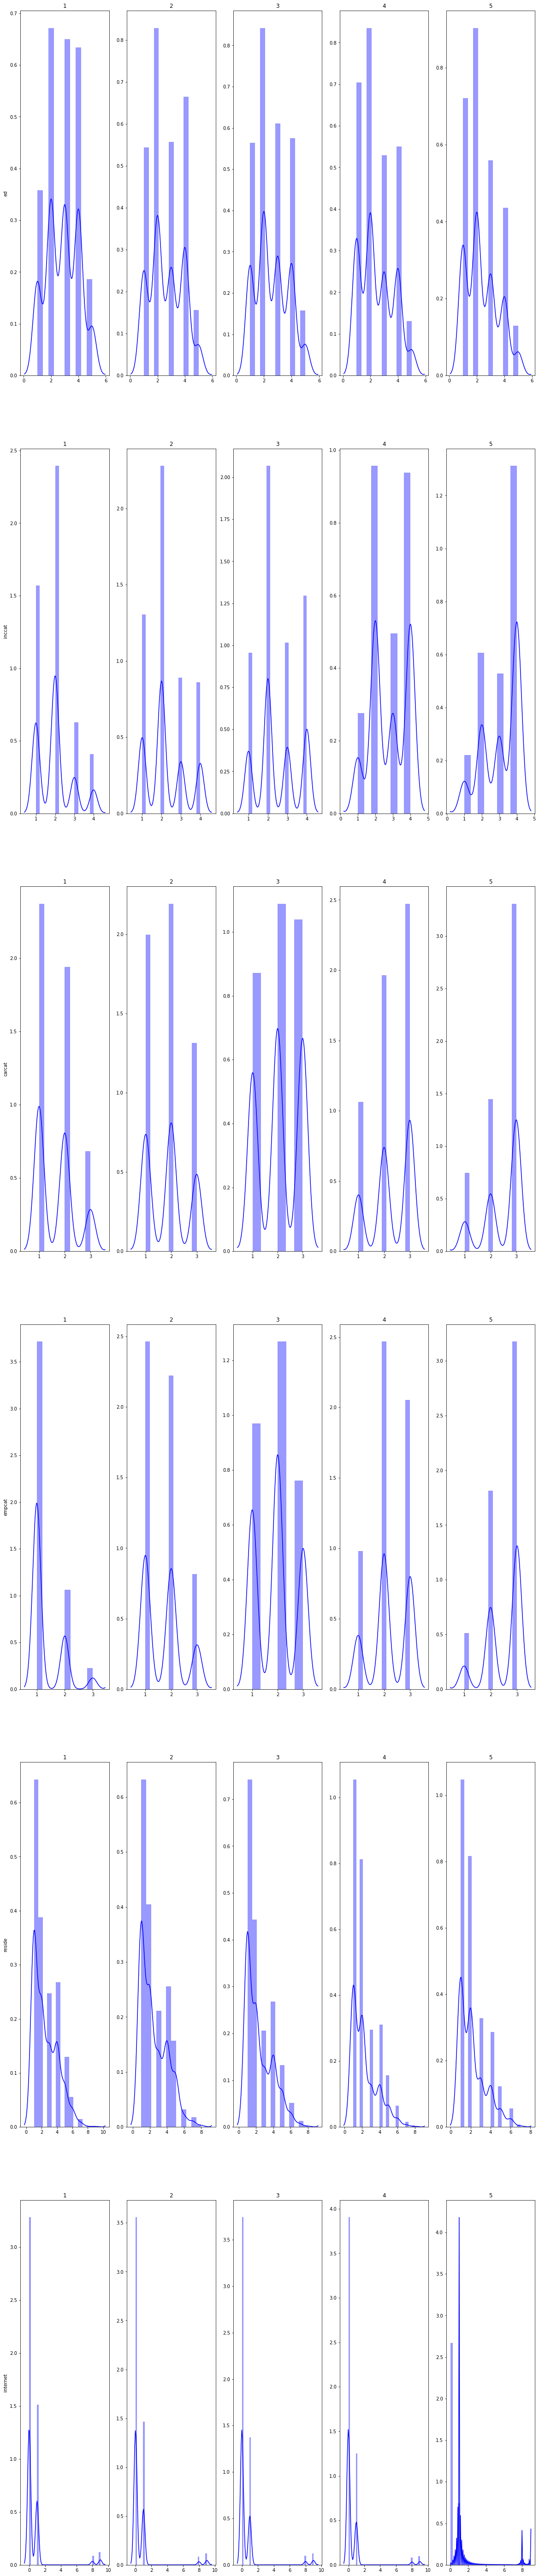

In [11]:
#cat_candidates
fig, ax = plt.subplots(len(cat_candidates),5,figsize=(20,len(bin_candidates)*6))
for n in range(len(cat_candidates)):
    feat = cat_candidates[n]
    for i in range(5):
        sns.distplot(np.array(known.loc[known['jobsat']==i+1][feat]), kde=True, ax=ax[n,i], color="Blue")
        ax[n,0].set_ylabel(feat)
        ax[n,i].set_title(i+1)

In [12]:
xknown = np.array(x_known.loc[:, list(set(features) - set(bin_candidates))])

### 1.2 Normalization

In [13]:
# del extras #if extras already exists
extras = extremums(xknown.T)

In [14]:
#Choose one

for array in xknown.T:
    normalize(array)

# xknown = prep.StandardScaler().fit(xknown).transform(xknown)

# 2. Models + selection

In [15]:
from sklearn import ensemble

### 2.1 Train - Test split

In [16]:
x_train, x_test, y_train, y_test = tt_split(xknown, yknown, ts=0.8, rs=1, sh=True)

### 2.2 Choose some model

In [17]:
#RFC
RFC = ensemble.RandomForestClassifier(n_estimators=100, criterion="gini",
                                      min_samples_leaf=1, min_samples_split=2)
RFC.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### 2.3 Check metrics

In [18]:
#RFC
test_metrics(y_test, RFC.predict(x_test))

[[95 33 23 22 11]
 [50 47 50 47 30]
 [34 58 28 50 70]
 [16 33 48 73 63]
 [ 3 16 29 54 97]]

 Mean Squeared Error = 2.1574074074074074


In [20]:
# #Fitting to metric
# l = []
# for elem in RFC.predict(x_test):
#     if 1<elem and elem<5:
#         l.append(3)
#     elif elem==1:
#         l.append(2)
#     elif elem==5:
#         l.append(4)
#     else:
#         l.append(elem)

# test_metrics(y_test, np.array(l))

In [19]:
#Why this dataset is pretty bad
print("Mean Squeared Error =", mse(y_test, np.array([3 for i in range(len(y_test))])))

Mean Squeared Error = 1.8416666666666666


### 2.4 Cross-validation and hyperparameters optimization

In [21]:
#RFC
samples_leaf, samples_split = range(1,11), range(2,12)
main = []
main_bar = tqdm(range(len(samples_leaf)))
inside_bar = tqdm(total=(len(samples_split)))
for i in main_bar:
    sl = samples_leaf[i]
    inside = []
    for ss in samples_split:
        x_train, x_test, y_train, y_test = tt_split(xknown, yknown, ts=0.8, rs=1, sh=True)
        RFC = ensemble.RandomForestClassifier(n_estimators=100, criterion="gini", min_samples_leaf=sl, min_samples_split=ss)
        RFC.fit(x_train, y_train)
        inside.append(round(mse(y_test, RFC.predict(x_test)), 4))
        inside_bar.update()
    inside_bar.refresh()
    inside_bar.reset()
    main.append(inside)
    
print(np.array(main))


[[2.2009 2.1444 2.1306 2.1565 1.9944 2.0398 2.0815 2.038  1.9861 2.0176]
 [2.0731 2.1009 2.0657 2.1269 2.0852 2.0824 1.937  2.0648 2.0537 2.0056]
 [2.0333 2.0519 2.0796 2.0278 2.0296 2.0204 1.9787 2.0204 2.0972 2.0731]
 [1.9259 2.0398 2.0722 2.0843 2.0306 2.0074 2.0093 1.9815 2.0056 1.9787]
 [1.9917 1.9787 2.0185 1.9583 1.9537 1.8954 1.9861 1.9176 1.9852 1.9426]
 [1.9889 1.9935 2.0074 1.9778 1.9731 2.0463 1.9602 1.9657 1.9546 1.9954]
 [1.9898 1.9074 1.9611 1.9704 1.9333 1.9704 2.0083 1.9917 1.9176 1.962 ]
 [1.9519 1.9269 1.9417 1.9935 1.9963 1.9667 1.9426 1.963  1.9778 2.0009]
 [1.9111 1.988  1.9222 1.9426 1.9889 1.9611 1.9713 1.938  1.9574 1.9556]
 [1.9648 1.9824 1.9185 1.9778 1.9778 1.9556 1.9898 1.9685 1.9676 1.9444]]


# 3. Prediction